In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf

%matplotlib inline

In [5]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11493376/11490434 [==============================] - 0s 0us/step


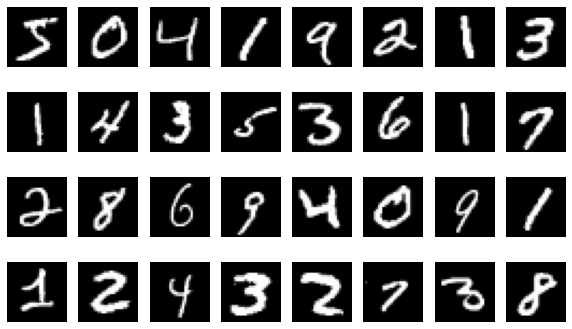

In [6]:
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j, :, :, 0], cmap='gray')
    ax.axis('off')

In [0]:
EMD_SIZE = 64

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),                             
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMD_SIZE, activation=None),    
])

In [0]:
MARGIN = 10.

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1-embs2), axis=1)
    d = tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)

    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)


In [0]:
BATCH_SIZE = 64
NUM_EPOCHS = 4

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [31]:
%%time

for iteraton, (images, labels) in enumerate(train_ds):
    
    # forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)

    # backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteraton % 200 == 0:
        print('[{:4d}] Loss: {:.3f}'.format(iteraton, loss_value))

[   0] Loss: 57.506
[ 200] Loss: 6.024
[ 400] Loss: 7.848
[ 600] Loss: 0.600
[ 800] Loss: 5.920
[1000] Loss: 1.568
[1200] Loss: 0.659
[1400] Loss: 3.454
[1600] Loss: 1.037
[1800] Loss: 1.746
[2000] Loss: 1.057
[2200] Loss: 1.588
[2400] Loss: 1.071
[2600] Loss: 0.256
[2800] Loss: 1.881
[3000] Loss: 0.963
[3200] Loss: 1.864
[3400] Loss: 0.562
[3600] Loss: 0.333
CPU times: user 33 s, sys: 517 ms, total: 33.6 s
Wall time: 33.2 s


In [0]:
test_embs = model(test_x)

In [0]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(10, 10))
    for class_idx in range(np.max(targets)+1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:, 0], X_embedded_class[:, 1])
    plt.legend(labels, loc='best')
    plt.grid(True)

In [0]:
test_x_flat = test_x.reshape(-1, 28*28)
test_x_2D = TSNE(n_components=2, random_state=21).fit_transform(test_x_flat[:1000])
labels_for_viz = test_y[:1000]

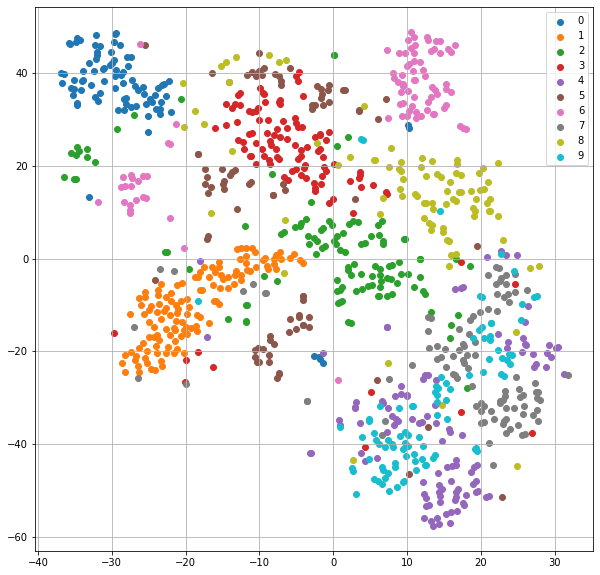

In [36]:
draw_embeddings(test_x_2D, labels_for_viz, list(range(10)))

In [0]:
test_x_2D = TSNE(n_components=2, random_state=21).fit_transform(test_embs[:1000])
labels_for_viz = test_y[:1000]

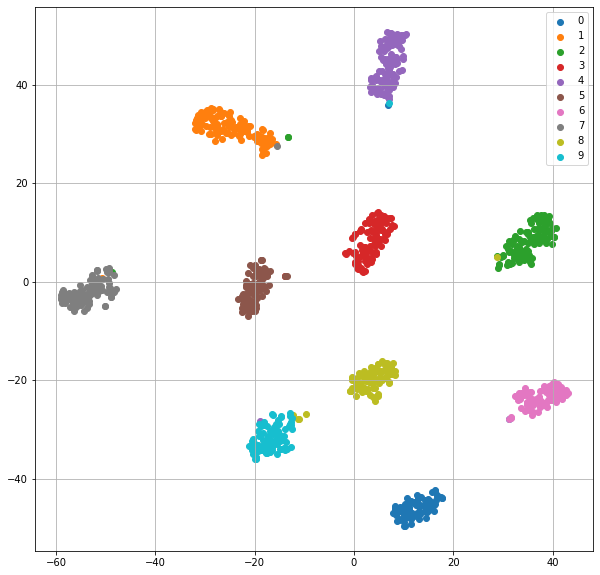

In [39]:
draw_embeddings(test_x_2D, labels_for_viz, list(range(10)))

In [0]:
import imageio
from skimage.transform import resize

def load_and_prepare_image(fpath):
    img = imageio.imread(fpath, pilmode='RGB')
    img = img.astype(np.float32) / 255.
    img = resize(img, (28, 28), order=3, mode='reflect', anti_aliasing=True)
    img = (1. - img).astype(np.float32)
    img = np.mean(img, axis=2)
    img = np.reshape(img, (28, 28, 1))
    return img

img_a1 = load_and_prepare_image('symbol_a1.PNG')
img_a2 = load_and_prepare_image('symbol_a2.PNG')
img_b1 = load_and_prepare_image('symbol_b1.PNG')

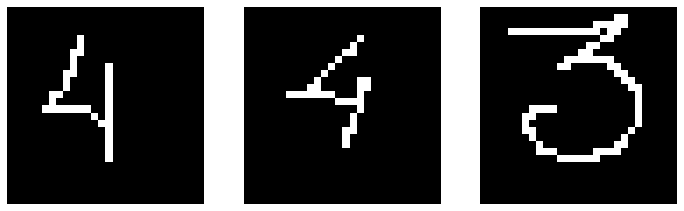

In [48]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1[:, :, 0], cmap='gray'); ax.axis('off')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2[:, :, 0], cmap='gray'); ax.axis('off')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1[:, :, 0], cmap='gray'); ax.axis('off')
plt.show()

In [0]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

In [61]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0, :]
emb2 = new_embs[1, :]
emb3 = new_embs[2, :]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  6.121695425019852
A2 <-> B1:  7.069312127088131
A1 <-> B1:  10.66201402600936
